In [ ]:
!pip install matplot lib
!pip install keras
!pip install tqdm
!pip3 install scikit-learn

In [9]:
from keras.callbacks import Callback
from tqdm import tqdm

class ProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']

    def on_epoch_begin(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.epochs}")
        self.progbar = tqdm(total=self.params['steps'])

    def on_batch_end(self, batch, logs=None):
        self.progbar.update(1)

    def on_epoch_end(self, epoch, logs=None):
        self.progbar.close()


In [11]:
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
import sys

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# normalize data
def normalize_data(train, test):
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	return train_norm, test_norm

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['acc'], color='blue', label='train')
	pyplot.plot(history.history['val_acc'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()


In [15]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from keras.optimizers import SGD

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32,  kernel_size = 3,kernel_initializer='he_normal', activation='relu', input_shape = (32, 32, 3)))
	model.add(BatchNormalization())
	
	model.add(Dropout(0.2))
	
	model.add(Conv2D(64, kernel_size = 3, kernel_initializer='he_normal', strides=1, activation='relu'))
	model.add(BatchNormalization())
	
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, kernel_size = 3, strides=1, kernel_initializer='he_normal' ,padding='same', activation='relu'))
	model.add(BatchNormalization())
	
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, kernel_size = 3,kernel_initializer='he_normal', activation='relu'))
	model.add(BatchNormalization())
	
	model.add(MaxPooling2D((4, 4)))
	model.add(Dropout(0.2))

	model.add(Flatten())
	model.add(Dense(256,kernel_initializer='he_normal', activation = "relu"))
	model.add(Dropout(0.1))
	model.add(Dense(10, kernel_initializer='glorot_uniform', activation = "softmax"))


	# Compile the model
	model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
	return model

In [20]:
# example of loading the cifar10 dataset
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

trainX, trainY, testX, testY = load_dataset()
trainX, testX = normalize_data(trainX,testX)

trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

model = define_model()
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
it_train = datagen.flow(trainX, trainY, batch_size=32)
steps = int(trainX.shape[0] / 64)

epochs_to_write = 50
filename = 'CNN-checkpointer-'+str(epochs_to_write)+'epochs.keras'

earlystopper = EarlyStopping(monitor='val_acc', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, 
                               verbose=1, mode='max', min_lr=0.00001)
checkpointer = ModelCheckpoint(filename, monitor='val_acc', verbose=1,
                               save_best_only=True)

In [6]:
from keras.models import load_model

model_to_load = 'models/CNN-0.829800009727478-80epochs.keras'
model = load_model(model_to_load)

Epoch 1/2


  0%|          | 0/625 [00:00<?, ?it/s]

100%|██████████| 625/625 [00:31<00:00, 19.86it/s]


Epoch 1: val_acc improved from 0.50400 to 0.55340, saving model to CNN-checkpointer-50epochs.keras


Epoch 2/2


100%|██████████| 625/625 [00:31<00:00, 20.05it/s]


Epoch 2: val_acc improved from 0.55340 to 0.59280, saving model to CNN-checkpointer-50epochs.keras


> 59.680


KeyError: 'accuracy'

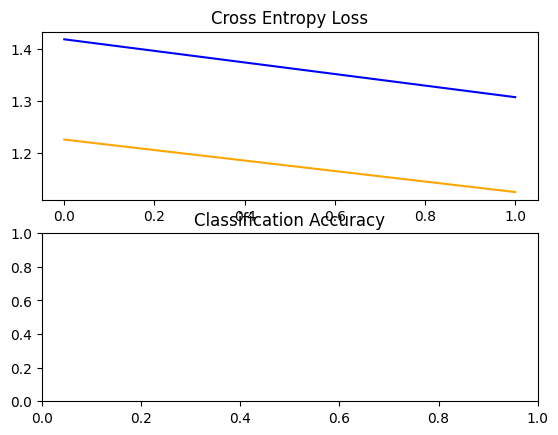

In [22]:
epochs = 2
history = model.fit(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(valX, valY), verbose=0, callbacks=[ProgressBar(),earlystopper,reduce_lr,checkpointer])
_, acc = model.evaluate(testX, testY, verbose=0)

print('> %.3f' % (acc * 100.0))
summarize_diagnostics(history)

In [ ]:
epochs_to_write = 60
model.save('CNN-'+str(acc)+'-'+str(epochs_to_write)+'epochs.keras')